# SageMaker 로 MNIST 모델 추론

### 실험 환경
- [SageMaker Notebook Instance](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi.html) 의 pytorch_p310 커널에서 테스트 되었습니다.
#### 참고 문서
- [[Module 2.1] 인퍼런스 스크래치](https://github.com/aws-samples/aws-ai-ml-workshop-kr/blob/master/sagemaker/recommendation/Neural-Collaborative-Filtering-On-SageMaker/2_Inference/2.1.NCF-Inference-Scratch.ipynb)

## 1. 환경 설정

In [1]:
%load_ext autoreload
%autoreload 2

### 이전 훈련 노트북에서 모델 저장 경로 가져오기

In [2]:
%store -r model_s3_path

print("model_s3_path: \n", model_s3_path)

model_s3_path: 
 s3://sagemaker-us-east-1-057716757052/sagemaker-101-pytorch-2024-06-23-02-17--2024-06-23-02-17-36-523/output/model.tar.gz


In [3]:
import glob
import os

# External Dependencies:
import matplotlib.pyplot as plt
import numpy as np

# Local Notebook Utils:
# import util

## 2. 로컬 추론 테스트

### 훈련 아티펙트 다운로드

In [4]:
local_model_dir = 'local_model'
os.makedirs(local_model_dir, exist_ok=True)

In [5]:
%%sh -s {model_s3_path} {local_model_dir}

model_s3_path=$1
local_model_dir=$2
# 모델을 S3에서 로컬로 다운로드
aws s3 cp $model_s3_path $local_model_dir

# 모델 다운로드 폴더로 이동
cd $local_model_dir

# 압축 해제
tar -xvf model.tar.gz

download: s3://sagemaker-us-east-1-057716757052/sagemaker-101-pytorch-2024-06-23-02-17--2024-06-23-02-17-36-523/output/model.tar.gz to local_model/model.tar.gz


tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'


model.pth


## 3.추론 함수 정의

### 모델 로딩 함수

In [6]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

local_model_dir = 'local_model'

device:  cuda


In [7]:
import os

def model_fn(model_dir):
    '''
    Load a model
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.jit.load(os.path.join(model_dir, 'model.pth'))
    model = model.to(device)
    print("## Model is successfully loaded")
    model.eval()
    
    return model

model = model_fn(local_model_dir)

## Model is successfully loaded


### payload 생성 함수

In [8]:
import json 
from PIL import Image

def create_payload(label, testing_dir):
    filename = os.listdir(f"{testing_dir}/{label}")[0]
    print("filename: ", filename)

    # Load the image:
    img = Image.open(f"{testing_dir}/{label}/{filename}")
    # normalize
    input_data = np.asarray(img).astype(np.float32)
    # input_data = np.expand_dims(input_data, [0, 1])  # Add batch & leading channel dim
    input_data = input_data.flatten().tolist()
    print("input_data: ", np.shape(input_data))

    payload = {
        'input': input_data, # input_data
        'resolution' : [28, 28]
    }

    return json.dumps(payload)


In [9]:
local_dir = "/tmp/mnist"
testing_dir = f"{local_dir}/testing"
payload = create_payload(label=2, testing_dir=testing_dir)
print("payload: \n", payload)


filename:  995.png
input_data:  (784,)
payload: 
 {"input": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.0, 255.0, 253.0, 232.0, 109.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 144.0, 253.0, 252.0, 252.0, 252.0, 156.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 160.0, 253.0, 252.0, 252.0, 252.0, 253.0, 190.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 252.0,

### input_fn 준비

In [10]:
import os
import json
import io

def input_fn(input_data, content_type):
    print("###############################")    
    print("## Starting Input_fn")
    print("###############################")   

    try: 
        if content_type == 'application/json':
            print("## content_type: ", content_type)
            # image data in the form of list type ( size: 784 = 28 * 28 )

            if isinstance(input_data, str):
                pass
            elif isinstance(input_data, io.BytesIO):
                print("## io.BytesIO")
                input_data = input_data.read()
                input_data = bytes.decode(input_data)        
            elif isinstance(input_data, bytes):
                print("## bytes:")                
                input_data = input_data.decode()
            else:
                raise ValueError(f"Unsupported data type: {type(input_data)}")        

            # print("## before json loads ")
            # print("## data type : \n", type(data))
            data = json.loads(input_data)["input"]
            # print("## after json loads : \n", data)
            # Get resolution ( [28, 28])
            resolution = json.loads(input_data)["resolution"]
            # print("## data: \n", data)
            
            # convert one dimenstion to two dimentions: 784 --> (28, 28)
            data = np.array(data).reshape(resolution)
            # normalize
            data = np.squeeze(data).astype(np.float32) / 255
            # (28, 28 ) --> (1, 1, 28, 28)
            data = torch.tensor(data).unsqueeze(0).unsqueeze(0)    
            print("## np.shape: ", np.shape(data))
        else:
            print("################################")
            raise ValueError(f"Unsupported content type: {content_type}")        
            print("################################")
    except Exception:
        print(traceback.format_exc())        


    return data

def input_fn(input_data, content_type):
    print("###############################")    
    print("## Starting Input_fn")
    print("###############################")   

    try: 
        if content_type == 'application/json':
            print("## content_type: ", content_type)
            # image data in the form of list type ( size: 784 = 28 * 28 )

            if isinstance(input_data, str):
                pass
            elif isinstance(input_data, io.BytesIO):
                input_data = input_data.read()
                input_data = bytes.decode(input_data)        
            elif isinstance(input_data, bytes):
                input_data = input_data.decode()

            data = json.loads(input_data)["input"]
            # Get resolution ( [28, 28])
            resolution = json.loads(input_data)["resolution"]
            print("## data: \n", data)
            
            # convert one dimenstion to two dimentions: 784 --> (28, 28)
            data = np.array(data).reshape(resolution)
            # normalize
            data = np.squeeze(data).astype(np.float32) / 255
            # (28, 28 ) --> (1, 1, 28, 28)
            data = torch.tensor(data).unsqueeze(0).unsqueeze(0)    
            print("## np.shape: ", np.shape(data))
        else:
            print("################################")
            raise ValueError(f"Unsupported content type: {content_type}")        
            print("################################")
    except Exception:
        print(traceback.format_exc())  

    return data    




input_data = input_fn(input_data=payload, content_type='application/json')



###############################
## Starting Input_fn
###############################
## content_type:  application/json
## data: 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63.0, 255.0, 253.0, 232.0, 109.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 144.0, 253.0, 252.0, 252.0, 252.0, 156.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 160.0, 253.0, 252.0, 252.0, 252.0, 253.0, 190.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

### predict_fn 준비

In [11]:
def predict_fn(input_data, model):
    '''
    모델의 추론 함수
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_data = input_data.to(device)
    # values = input_data.squeeze().tolist()
    # print("input sum: ", np.sum(values))
    print("shape: ", np.shape(input_data))
    
    with torch.no_grad():
        result = model(input_data)
    print(f"## Result confidences: {result}")

    return result

result = predict_fn(input_data=input_data, model=model)


shape:  torch.Size([1, 1, 28, 28])
## Result confidences: tensor([[1.1233e-05, 6.4257e-10, 9.9999e-01, 9.8468e-08, 2.1759e-11, 1.7181e-12,
         9.0501e-11, 1.1180e-08, 7.9277e-10, 6.0489e-11]], device='cuda:0')


### Output_fn 준비

In [12]:
def output_fn(prediction, content_type):

    if content_type == 'application/json':
        # convert tensor type to list type
        values = prediction.squeeze().tolist()

    return json.dumps(values)

In [13]:
output = output_fn(prediction=result, content_type='application/json')
output = json.loads(output)
print("output: ", output)


max_index = np.argmax(output)
print("## Max confidence index:", max_index)

output:  [1.1233007171540521e-05, 6.42566944097922e-10, 0.9999886751174927, 9.846751680697707e-08, 2.1758643498070995e-11, 1.718074575836337e-12, 9.050087068640522e-11, 1.1180278924882714e-08, 7.927744571922801e-10, 6.048894024557327e-11]
## Max confidence index: 2


### 전체 로컬 추론 테스트

In [14]:
from PIL import Image

def predict_mnist(label, local_model_dir, testing_dir ):

    # Handle input
    # Load the image:
    filename = os.listdir(f"{testing_dir}/{label}")[0]
    print("previous filename: ", filename)
    img = Image.open(f"{testing_dir}/{label}/{filename}")

    # load model
    model = model_fn(local_model_dir)

    # load input_data
    payload = create_payload(label=label, testing_dir=testing_dir)
    # print("## label: ", label)
    # print("## payload: \n", payload)    
    input_data = input_fn(input_data=payload, content_type='application/json')

    # print("## input_data shape: ", np.shape(input_data))

    # predict label
    result = predict_fn(input_data=input_data, model=model)

    # output 
    output = output_fn(prediction=result, content_type='application/json')
    output = json.loads(output)    
    # print("## output: ", output)

    max_index = np.argmax(output)
    print("## Max confidence index:", max_index)    
    
    # Plot the result:
    plt.figure(figsize=(3, 3))
    fig = plt.subplot(1, 1, 1)
    ax = plt.imshow(img, cmap="gray")
    fig.set_title(f"Predicted Number {max_index}")
    plt.show()


previous filename:  5479.png
## Model is successfully loaded
filename:  5479.png
input_data:  (784,)
###############################
## Starting Input_fn
###############################
## content_type:  application/json
## data: 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.0, 120.0, 164.0, 254.0, 254.0, 254.0, 157.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

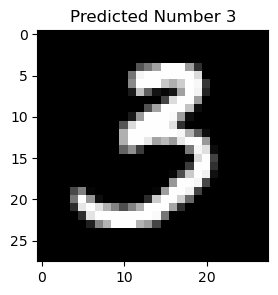

In [15]:


predict_mnist(label=3, local_model_dir=local_model_dir, testing_dir=testing_dir )    

previous filename:  3501.png
## Model is successfully loaded
filename:  3501.png
input_data:  (784,)
###############################
## Starting Input_fn
###############################
## content_type:  application/json
## data: 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

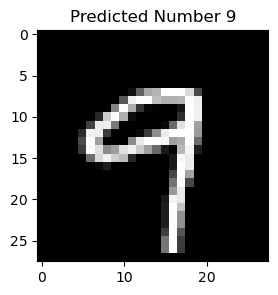

In [16]:
predict_mnist(label=9, local_model_dir=local_model_dir, testing_dir=testing_dir )    

## 4. Local 에서 SageMaker Endpoint 추론

In [17]:
local_model_path = os.path.join(local_model_dir, 'model.tar.gz')
print("local_model_path: ", local_model_path)

local_model_path:  local_model/model.tar.gz


### instance_type 을 local_gpu or local 지정

In [18]:
instance_type = 'local_gpu' if torch.cuda.is_available() else 'local'
print("Instance type = " + instance_type)

Instance type = local_gpu


### sagemaker.pytorch.model.PyTorchModel 생성

In [19]:
import os
import time
import sagemaker
from sagemaker.pytorch.model import PyTorchModel
from sagemaker import get_execution_role
role = get_execution_role()
sess = sagemaker.Session()


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/SageMaker/.xdg/config/sagemaker/config.yaml


In [20]:
import time
endpoint_name = "local-endpoint-mnist-{}".format(int(time.time()))

local_pytorch_model = PyTorchModel(model_data=local_model_path,
                                   role=role,
                                   entry_point='inference.py',
                                   source_dir = 'src',
                                   framework_version='2.0.1',
                                   py_version='py310',
                                   model_server_workers=1,
                                  )



### 로컬 SageMaker Endpoint 배포

In [21]:
local_predictor = local_pytorch_model.deploy(
                           instance_type=instance_type, 
                           initial_instance_count=1, 
                           endpoint_name=endpoint_name,
                           wait=True,
                           log = False,
                        )

Attaching to p9b20mvuwr-algo-1-jyvao
p9b20mvuwr-algo-1-jyvao  | ['torchserve', '--start', '--model-store', '/.sagemaker/ts/models', '--ts-config', '/etc/sagemaker-ts.properties', '--log-config', '/opt/conda/lib/python3.10/site-packages/sagemaker_pytorch_serving_container/etc/log4j2.xml', '--models', 'model=/opt/ml/model']
p9b20mvuwr-algo-1-jyvao  | Warning: TorchServe is using non-default JVM parameters: -XX:-UseContainerSupport
p9b20mvuwr-algo-1-jyvao  | WARNING: sun.reflect.Reflection.getCallerClass is not supported. This will impact performance.
p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:26:05,270 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:26:05,273 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:

## 5. 로컬 엔드포인트 추론

### payload 생성

In [22]:
test_label = 3
payload = create_payload(label= test_label, testing_dir=testing_dir)
print("## payload: \n", payload)    
    

filename:  5479.png
input_data:  (784,)
## payload: 
 {"input": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.0, 120.0, 164.0, 254.0, 254.0, 254.0, 157.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 117.0, 245.0, 254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 219.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 137.0, 2

### sagemaker runtime_client 생성

In [23]:
import boto3

def get_sm_runtime_client(instance_type):
    if instance_type in ['local_gpu', 'local']:
        runtime_client = sagemaker.local.LocalSagemakerRuntimeClient()    
        print("runtime_client: ", runtime_client)
    else:
        runtime_client = boto3.Session().client('sagemaker-runtime')
        print("runtime_client: ", runtime_client)    

    return runtime_client        


runtime_client = get_sm_runtime_client(instance_type)


runtime_client:  <sagemaker.local.local_session.LocalSagemakerRuntimeClient object at 0x7fbca21ade10>


### boto3 invoke_endpoint() 호출

In [24]:
import json

start_time = time.time()

def boto3_invoke_endpoint(runtime_client, endpoint_name, payload):

        response = runtime_client.invoke_endpoint(
                EndpointName=endpoint_name, 
                ContentType='application/json', 
                Body=payload,
                )

        return response

response = boto3_invoke_endpoint(runtime_client, endpoint_name, payload)        




p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:26:38,549 [INFO ] epollEventLoopGroup-3-2 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:7c5b5652efca,timestamp:1719131198
p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:26:38,551 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1719131198551
p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:26:38,554 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - ###############################
p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:26:38,555 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - ## Model is successfully loaded
p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:26:38,555 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - ###############################
p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:26:38,556 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1719131198
p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:26:38,918 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - ##

In [25]:
def parse_output(response):
    result = response['Body'].read().decode().splitlines()                            
    print('result: ', result)
    output = json.loads(result[0])
    print('output: ', output)

    max_index = np.argmax(output)
    print("## Max confidence index:", max_index)    
    
parse_output(response)
    

p9b20mvuwr-algo-1-jyvao  | 2024-06-23T08:26:38,928 [INFO ] W-9000-model_1.0-stdout MODEL_METRICS - PredictionTime.ms:363.73|#ModelName:model,Level:Model|#hostname:7c5b5652efca,requestID:3564911c-29d5-4322-a730-b22cc8553f4f,timestamp:1719131198


result:  ['[3.5067052207978996e-14, 3.142335835981669e-10, 4.4553388213984524e-13, 0.9999996423721313, 3.2763954377801503e-16, 4.0042363025349914e-07, 6.445760131158426e-14, 6.852785266325823e-12, 1.901922846644921e-12, 2.3169910434717167e-10]']
output:  [3.5067052207978996e-14, 3.142335835981669e-10, 4.4553388213984524e-13, 0.9999996423721313, 3.2763954377801503e-16, 4.0042363025349914e-07, 6.445760131158426e-14, 6.852785266325823e-12, 1.901922846644921e-12, 2.3169910434717167e-10]
## Max confidence index: 3


## 6. 로컬 엔드포인트 삭제

In [26]:
def delete_endpoint(client, endpoint_name):
    print("#### Start")
    response = client.describe_endpoint(EndpointName=endpoint_name)
    EndpointConfigName = response['EndpointConfigName']    
    
    response = client.describe_endpoint_config(EndpointConfigName=EndpointConfigName)
    
    model_name = response['ProductionVariants'][0]['ModelName']


    print(f'--- Deleted model: {model_name}')
    print(f'--- Deleted endpoint: {endpoint_name}')
    print(f'--- Deleted endpoint_config: {EndpointConfigName}')    
    
    client.delete_model(ModelName=model_name)    
    client.delete_endpoint_config(EndpointConfigName=EndpointConfigName)        
    client.delete_endpoint(EndpointName=endpoint_name)

client = sagemaker.local.LocalSagemakerClient()
delete_endpoint(client, endpoint_name)



#### Start
--- Deleted model: pytorch-inference-2024-06-23-08-26-01-526
--- Deleted endpoint: local-endpoint-mnist-1719131160
--- Deleted endpoint_config: local-endpoint-mnist-1719131160


## 7. SageMaker Endpoint 생성 

In [27]:
instance_type = 'ml.m5.xlarge' 

In [28]:
import time
sm_endpoint_name = "sm-endpoint-mnist-{}".format(int(time.time()))

sm_pytorch_model = PyTorchModel(model_data=local_model_path,
                                   role=role,
                                   entry_point='inference.py',
                                   source_dir = 'src',
                                   framework_version='2.0.1',
                                   py_version='py310',
                                   model_server_workers=1,
                                  )

In [29]:
sm_predictor = sm_pytorch_model.deploy(
                           instance_type=instance_type, 
                           initial_instance_count=1, 
                           endpoint_name=sm_endpoint_name,
                           wait=True,
                           log = False,
                        )

-----!

## 8. SageMaker Endpoint 추론

In [30]:
test_label = 3
payload = create_payload(label= test_label, testing_dir=testing_dir)
print("## payload: \n", payload)    


runtime_client = get_sm_runtime_client(instance_type)
response = boto3_invoke_endpoint(runtime_client, sm_endpoint_name, payload)        
parse_output(response)
    

filename:  5479.png
input_data:  (784,)
## payload: 
 {"input": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.0, 120.0, 164.0, 254.0, 254.0, 254.0, 157.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 117.0, 245.0, 254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 219.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 137.0, 2

## 9. SageMaker Endpoint 삭제

In [31]:
client = boto3.Session().client('sagemaker')
delete_endpoint(client,sm_endpoint_name)

#### Start
--- Deleted model: pytorch-inference-2024-06-23-08-26-52-875
--- Deleted endpoint: sm-endpoint-mnist-1719131211
--- Deleted endpoint_config: sm-endpoint-mnist-1719131211
